# Pneumothorax Classifier with SIIMS

**References:**
- https://www.youtube.com/watch?v=93kXzUOiYY4
- https://colab.research.google.com/drive/1mVISoBYTDk3Q9D5VmviTkYD28WlFW-Jk#scrollTo=miSJjgU6PZ5Z
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [17]:
from google.colab import drive
drive.mount('/content/drive')
import glob
import matplotlib.pyplot as plt
!pip3 install pickle5
import pickle5 as pickle
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img,img_to_array, load_img
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import shutil
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load IU Images and SIIMs Images

In [ ]:
with open('/content/drive/MyDrive/iu_image/analysis/output/pneumothorax_neg_dict.pickle', 'rb') as handle:
    pneumothorax_neg_dict=pickle.load(handle)

with open('/content/drive/MyDrive/iu_image/analysis/output/pneumothorax_pos_dict.pickle', 'rb') as handle:
    pneumothorax_pos_dict=pickle.load(handle)

In [ ]:
pos_img_idx_lst=[j for i in pneumothorax_pos_dict for j in pneumothorax_pos_dict[i]]
neg_img_idx_lst=[j for i in pneumothorax_neg_dict for j in pneumothorax_neg_dict[i]]

print("There are {} positive images and {} negative images".format(len(pos_img_idx_lst),len(neg_img_idx_lst)))

There are 20 positive images and 4407 negative images


# Split the Data for Training

In [ ]:
for file in glob.glob('/content/drive/MyDrive/iu_image/analysis/input/NLMCXR_png/*.png'):
    file_split_1=file.split(".")
    file_split_2=file_split_1[0].split("/")
    img_indx=file_split_2[-1]
    
    if img_indx in pos_img_idx_lst:
      shutil.copy(file, '/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs/positive')
    if img_indx in neg_img_idx_lst:
      shutil.copy(file, '/content/drive/MyDrive/iu_image/analysis/output/neg_iu_imgs')


# Integrate Siims Data for Training

- Add all the positive images to positive training images
- Randomly select 2,500 negative IU images for training

In [ ]:
for file in glob.glob('/content/drive/MyDrive/iu_image/analysis/input/siim/pneumothorax/*'):
  shutil.copy(file, '/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs/positive')

In [ ]:
cnt_p_imgs=0
for path in os.listdir('/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs/positive'):
  cnt_p_imgs+=1
print("There are {} positive images".format(cnt_p_imgs))

There are 2519 positive images


In [18]:
neg_files=[f for f in os.listdir('/content/drive/MyDrive/iu_image/analysis/output/neg_iu_imgs')]

print("There are {} negative images from IU".format(len(neg_files)))

random_iu_neg_files=np.random.choice(neg_files,2519,replace=False)
print(print("There are {} random negative image files from IU".format(len(random_iu_neg_files))))

There are 4407 negative images from IU
There are 2519 random negative image files from IU
None


In [20]:
neg_f_indx_lst=[]
for f in random_iu_neg_files:
  f=f.split(".")
  f_indx=f[0]
  f_indx=f_indx.strip()
  neg_f_indx_lst.append(f_indx)

print(len(neg_f_indx_lst))

2519


In [21]:
for file in glob.glob('/content/drive/MyDrive/iu_image/analysis/output/neg_iu_imgs/*'):
    file_split_1=file.split(".")
    file_split_2=file_split_1[0].split("/")
    img_indx=file_split_2[-1]
    
    if img_indx in neg_f_indx_lst:
      shutil.copy(file, '/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs/negative')

In [22]:
neg_files_train=[f for f in os.listdir('/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs/negative')]
print(print("There are {} random negative image files from IU for training".format(len(neg_files_train))))

There are 2519 random negative image files from IU for training
None


In [23]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory="/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5038 files belonging to 2 classes.
Using 4031 files for training.


# Split the Data for Validation

In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory="/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5038 files belonging to 2 classes.
Using 1007 files for validation.


# Visualize the Data

In [26]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classnames,c_indx_dict=find_classes('/content/drive/MyDrive/iu_image/analysis/output/siims_iu_imgs')

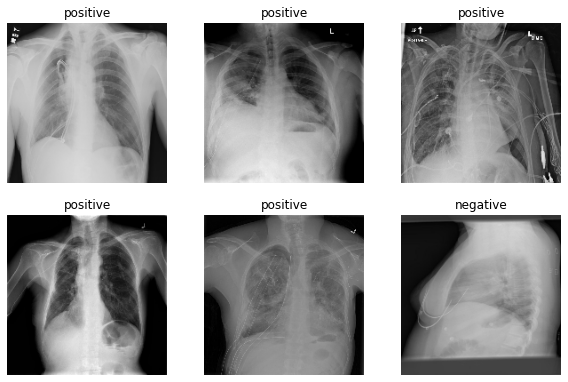

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

# Import Pre-Trained Model

While importing the ResNet50 class, the weights are learned on the imagenet data, ensuring that the model does not learn the weights again, saving time and space complexity.The custom input and output layers will be developed according to our data.


In [31]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

# Add fully connected and output layer where actual learning can take place

Use the softmax activation function and add 1 output neurons corresponding to the 2 classes in the data

In [32]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


# Compile and Train for 50 Epochs

In [33]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

history=resnet_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
126/126 [==============================] - 647s 5s/step - loss: 0.3551 - accuracy: 0.4949 - val_loss: 0.1871 - val_accuracy: 0.5204
Epoch 2/20
126/126 [==============================] - 635s 5s/step - loss: 0.1678 - accuracy: 0.4949 - val_loss: 0.1582 - val_accuracy: 0.5204
Epoch 3/20
126/126 [==============================] - 635s 5s/step - loss: 0.1149 - accuracy: 0.4949 - val_loss: 0.1449 - val_accuracy: 0.5204
Epoch 4/20
126/126 [==============================] - 634s 5s/step - loss: 0.0862 - accuracy: 0.4949 - val_loss: 0.1319 - val_accuracy: 0.5204
Epoch 5/20
126/126 [==============================] - 631s 5s/step - loss: 0.0712 - accuracy: 0.4949 - val_loss: 0.1496 - val_accuracy: 0.5204
Epoch 6/20
126/126 [==============================] - 631s 5s/step - loss: 0.0576 - accuracy: 0.4949 - val_loss: 0.1279 - val_accuracy: 0.5204
Epoch 7/20
126/126 [==============================] - 633s 5s/step - loss: 0.0421 - accuracy: 0.4949 - val_loss: 0.1233 - val_accuracy: 0.5204

# Model Evaluation

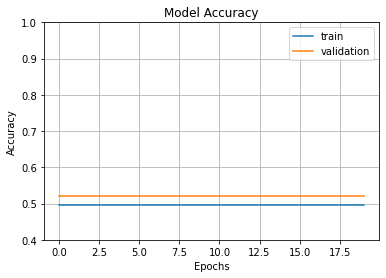

In [37]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('/content/drive/MyDrive/iu_image/analysis/output/siims_iu_performance.png')
plt.show()

<Figure size 432x288 with 0 Axes>